In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


data = pd.read_csv('HH_Provider_Oct2023.csv')

data.replace('-', 0, inplace=True)

# scoate stringurile din coloanele numerice
numeric_columns = data.select_dtypes(include='number').columns
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# nu avem duplicate, dar daca am fi avut, le-am fi eliminat cu:
data.drop_duplicates(inplace=True)


print("show current data:")
data

In [255]:
class FeedbackHHC:
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
    def type_number(self, column):
        for value in self.data[column]:
            if value != '-':
                try:
                    float(value)
                    return True
                except ValueError:
                    return False
            return True

    def preprocessdata(self):

        #eliminam duplicatele
        self.data.drop_duplicates(inplace=True)

        self.data.drop(['Certification Date','Footnote for how often patients got better at taking their drugs correctly by mouth','Footnote for how often patients got better at walking or moving around','Footnote for how often the home health team determined whether patients received a flu shot for the current flu season','Footnote for how much Medicare spends on an episode of care at this agency, compared to '
                        'Medicare spending across all agencies nationally', 'Footnote for PPR Risk-Standardized Rate',
                        'Footnote for DTC Risk-Standardized Rate', 'Footnote for Application of Percent of Long Term '
                                                                   'Care Hospital Patients with an Admission and '
                                                                   'Discharge Functional Assessment and a Care Plan '
                                                                   'that Addresses Function', 'Footnote for Percent of '
                                                                                              'Residents Experiencing '
                                                                                              'One or More Falls with '
                                                                                              'Major Injury',
                        'Footnote for how often physician-recommended actions to address medication issues were '
                        'completely timely', 'Footnote Changes in skin integrity post-acute care: pressure '
                                             'ulcer/injury', 'Footnote for how often patients receiving home health '
                                                             'care needed urgent, unplanned care in the ER without '
                                                             'being admitted', 'Footnote for how often home health '
                                                                               'patients had to be admitted to the '
                                                                               'hospital', 'Footnote for how often '
                                                                                           'patients got better at '
                                                                                           'taking'
                                                                                           'their drugs correctly by '
                                                                                           'mouth', 'Footnote for how '
                                                                                                    'often patients\' '
                                                                                                    'breathing improved',
                        'Footnote for how often patients got better at bathing', 'Footnote for how often patients got '
                                                                                 'better at getting in and out of '
                                                                                 'bed', 'Footnote for how often '
                                                                                        'patients got better at walking'
                                                                                        'or moving around',
                        'Footnote for how'
                        'often the home '
                        'health team '
                        'determined whether '
                        'patients received a '
                        'flu shot for the '
                        'current flu '
                        'season',
                        'Footnote for how often the home health team began their patients\' care in a timely manner',
                        'Footnote for PPH Risk-Standardized Rate', 'Footnote for quality of patient care star rating',
                        'Provider ID', 'Provider Name', 'Hospital Name', 'Address', 'City/Town', 'State', 'ZIP Code',
                        'County Name', 'Telephone Number', 'Hospital Type', 'Type of Ownership', 'Emergency '
                                                                                                 'Services',
                        'Meets criteria for meaningful use of EHRs', 'Hospital overall rating', 'Mortality national '
                                                                                                'comparison',
                        'Safety of care national comparison', 'Readmission national comparison', 'Patient experience '
                                                                                                 'national '
                                                                                                 'comparison',
                        'Effectiveness of care national comparison', 'Timeliness of care national comparison',
                        'Efficient use of medical imaging national comparison', 'CMS Certification Number (CCN)'],
                       axis=1, inplace=True, errors='ignore')
        
        # delete rows with value '-' instead of 'Yes' or 'No'
        yes_no_columns = [
            'Offers Nursing Care Services',
            'Offers Physical Therapy Services',
            'Offers Occupational Therapy Services',
            'Offers Speech Pathology Services',
            'Offers Medical Social Services',
            'Offers Home Health Aide Services'
        ]
        for col in yes_no_columns:
            self.data[col].replace('-', np.nan, inplace=True)
        self.data.dropna(subset=yes_no_columns, how='any', inplace=True)

        # replace 'Yes' in columns with 1 and 'No' with 0
        self.data.replace('Yes', 1, inplace=True)
        self.data.replace('No', 0, inplace=True)

        # stergem coloanele care au mai mult de 70% din randuri goale
        for col in self.data.columns:
            if self.data[col].isnull().sum() > 0.7 * len(self.data[col]):
                self.data.drop(col, axis=1, inplace=True)

        # inlocuim celulele goale cu valoarea 0
        for col in self.data.columns:
            if self.type_number(col):
                self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
                self.data[col].fillna(0, inplace=True)
                self.data[col].replace('-', 0, inplace=True)

        #inlocuim valorile numerice lipsa cu media
        for col in self.data.columns:
            if self.type_number(col):
                self.data[col].fillna(self.data[col].mean(), inplace=True)

        # scapam de outlieri
        numeric_columns = [col for col in self.data.columns if self.type_number(col)]
        numeric_data = self.data[numeric_columns]
        numeric_data.apply(pd.to_numeric, errors='coerce')

        Q1 = numeric_data.quantile(0.25)
        Q3 = numeric_data.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((numeric_data < lower_bound) | (numeric_data > upper_bound)).any(axis=1)
        for index, _ in self.data.iterrows():
            if outliers[index]:
                self.data.drop(index)
        

    def exploratory_analysis(self):
        numeric_columns = [col for col in self.data.columns if self.type_number(col)]
        numeric_data = self.data[numeric_columns]
        mean_values = numeric_data.mean()
        median_values = numeric_data.median()

        print("Valorile medii:\n", mean_values)
        print("\nValorile mediane:\n", median_values)

        #vizualizarea datelor sub forma de histograma
        numeric_columns = [col for col in self.data.columns if self.type_number(col)]
        numeric_data = self.data[numeric_columns]

        for col in numeric_columns:
            plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
            numeric_data[col].hist()
            plt.title(col)
            plt.show()

    def select_attributes(self):
        # selectam atributele folosind PCA
        numeric_columns = [col for col in self.data.columns if self.type_number(col)]
        numeric_data = self.data[numeric_columns]
        pca=PCA()
        pca.fit(numeric_data)
        # calculam variația cumulativă și determinam numarul de componente
        variatie_cumulativa = np.cumsum(pca.explained_variance_ratio_)
        numar_componente = np.where(variatie_cumulativa > 0.95)[0][0] + 1

        # aplicam PCA cu numarul optim de componente
        pca_optim = PCA(n_components=numar_componente)
        pca_optim.fit(numeric_data)

        # afisam atributele selectate
        print("Atributele selectate sunt:")
        print("--------------------------------------------------------------------------------------------------------------------------------------------")
        print()
        for i in range(numar_componente):
            print(f"Componenta principală {i + 1}:")
            component = pca_optim.components_[i]
            importance = pd.Series(component, index=numeric_columns)
            print(importance.sort_values(ascending=False))
            print()

        #vizualizarea atributelor selectate
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
        plt.xlabel('Numărul de componente')
        plt.ylabel('Variația explicată cumulativ')
        plt.title('Variația cumulată a varianței explicată')
        plt.grid()
        plt.show()

The average for the attributes:
 Offers Nursing Care Services                                                                                                                                  0.998886
Offers Physical Therapy Services                                                                                                                              0.995357
Offers Occupational Therapy Services                                                                                                                          0.964896
Offers Speech Pathology Services                                                                                                                              0.915676
Offers Medical Social Services                                                                                                                                0.872585
Offers Home Health Aide Services                                                                                                    

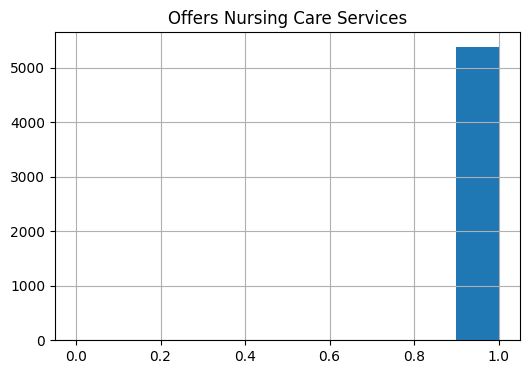

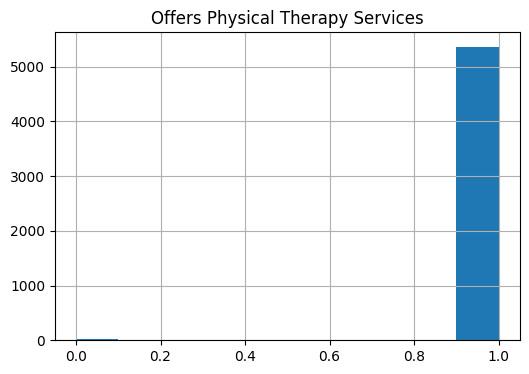

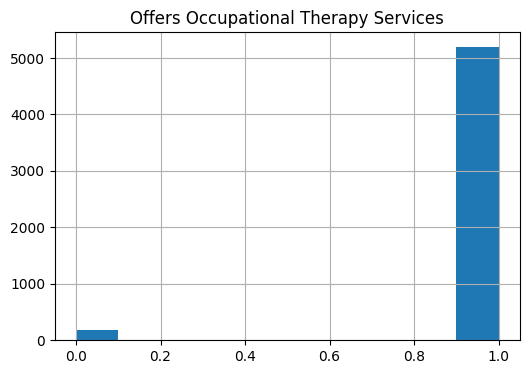

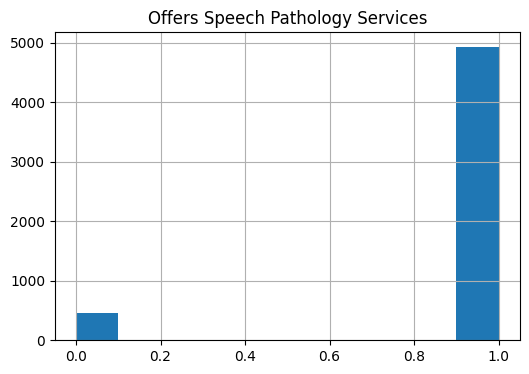

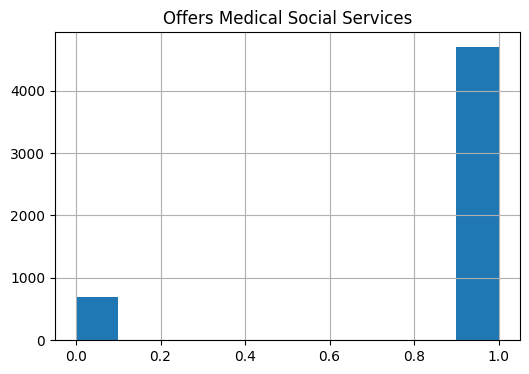

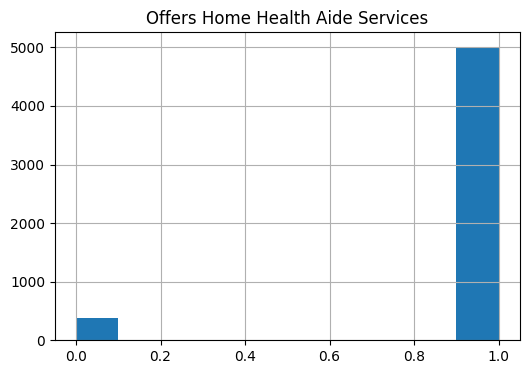

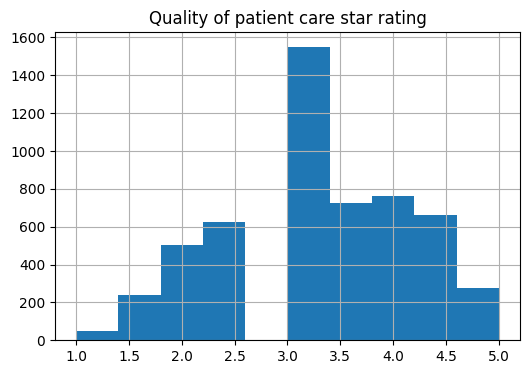

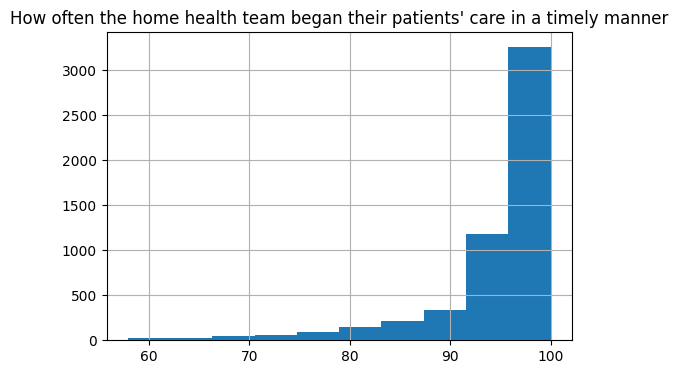

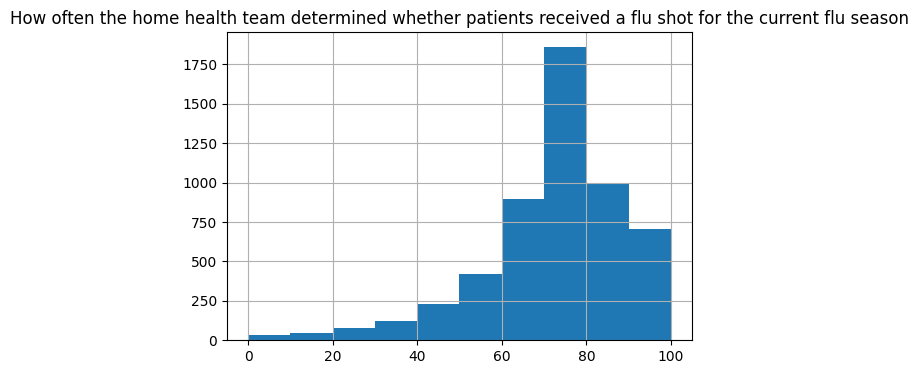

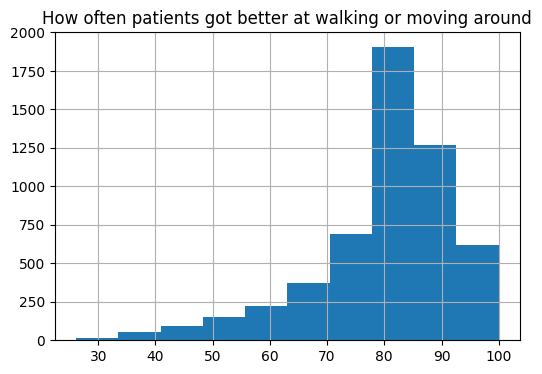

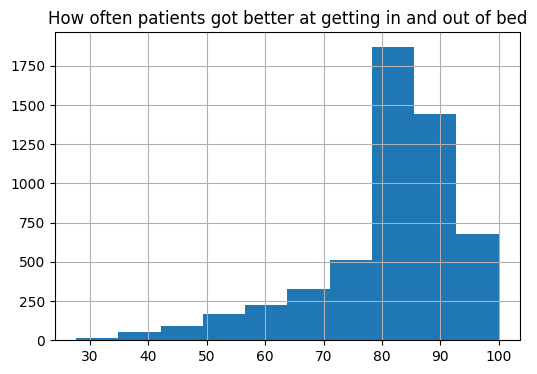

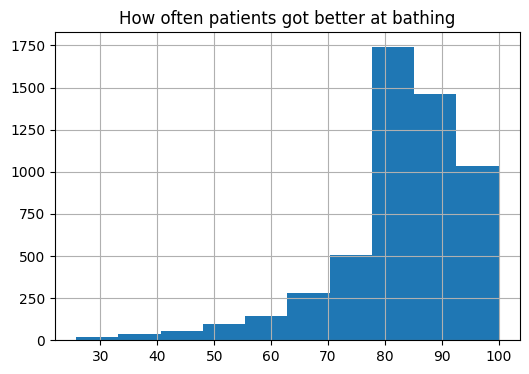

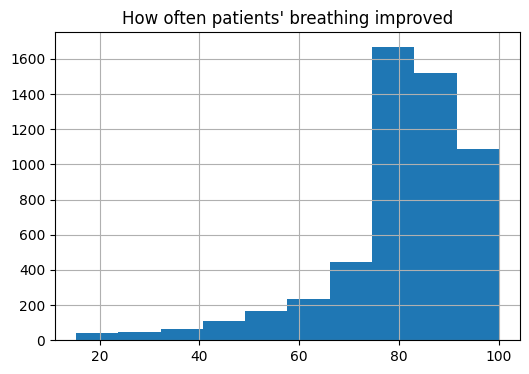

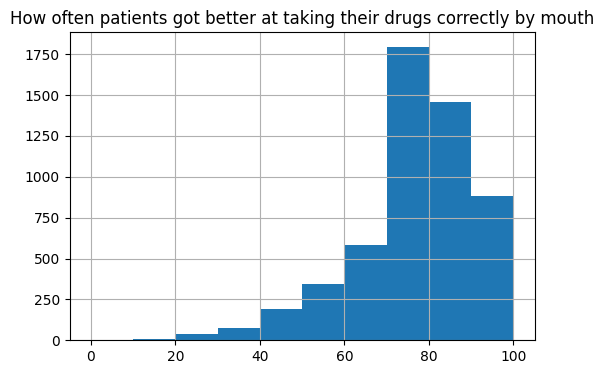

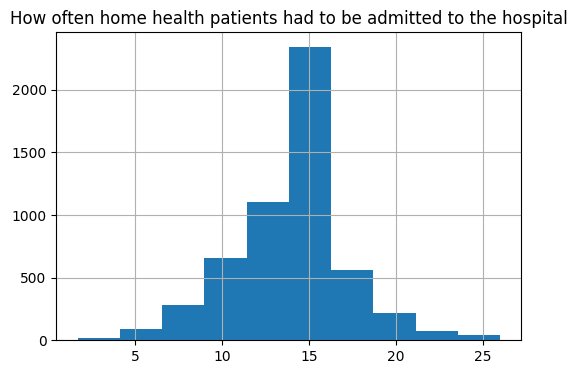

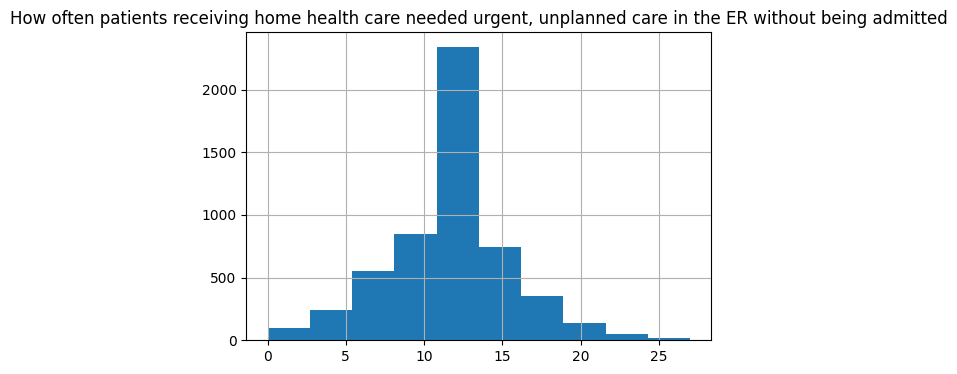

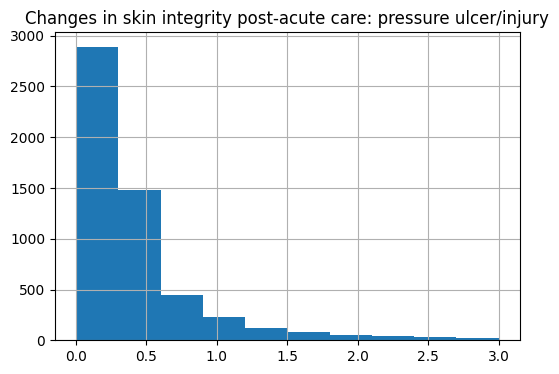

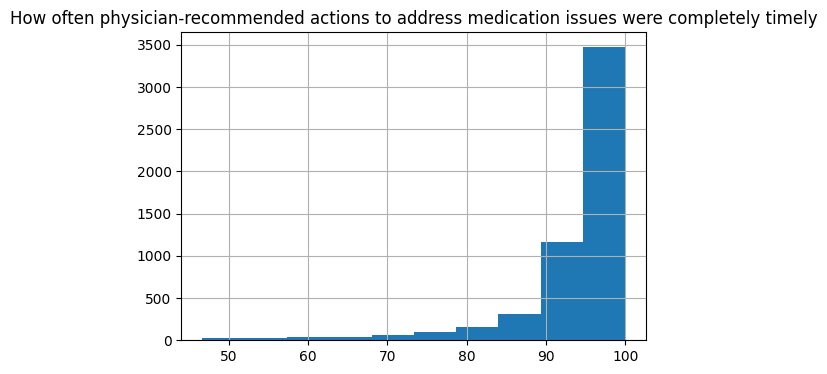

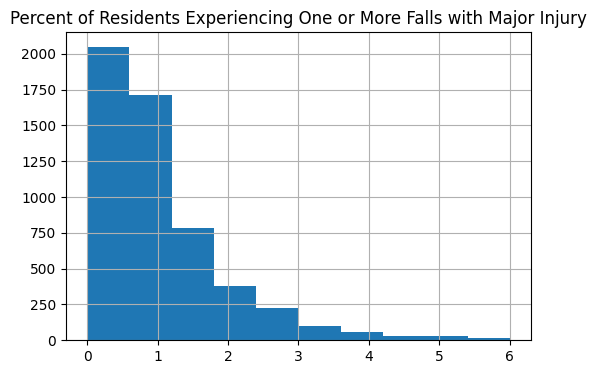

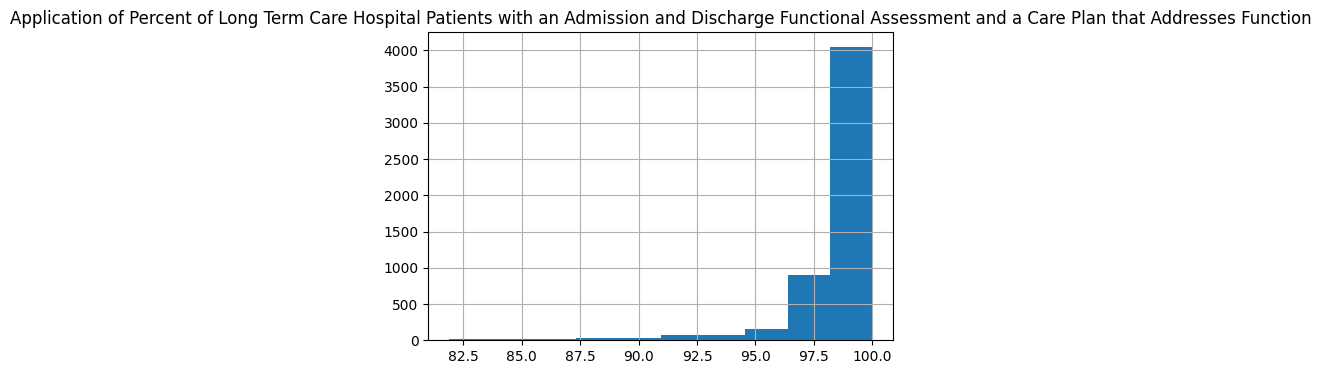

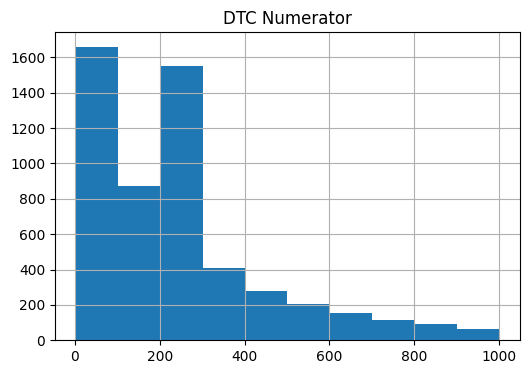

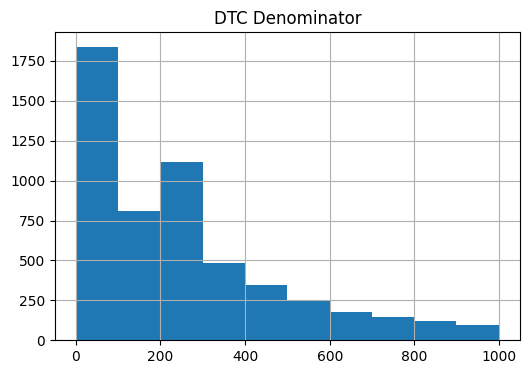

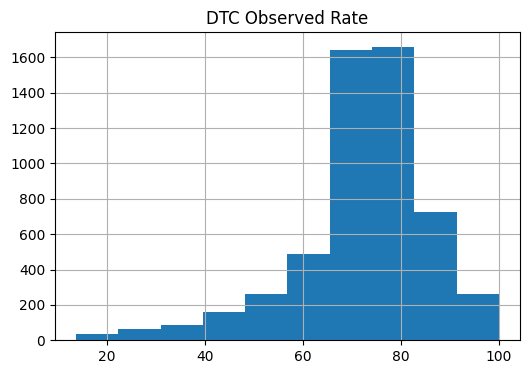

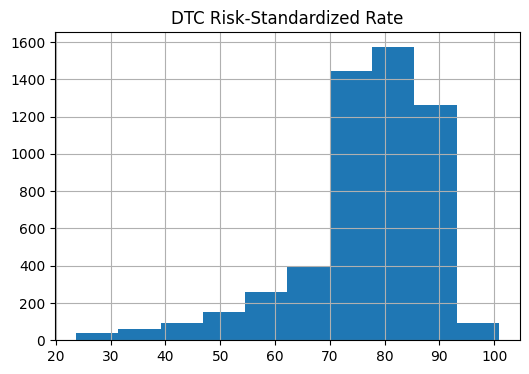

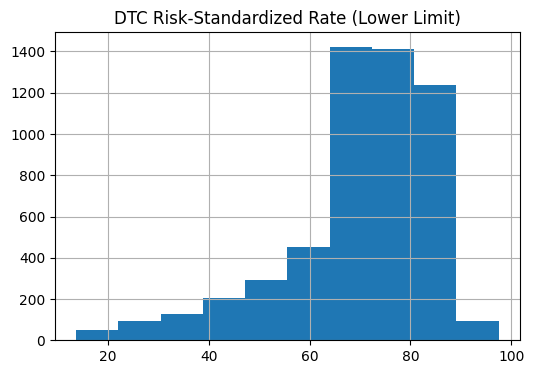

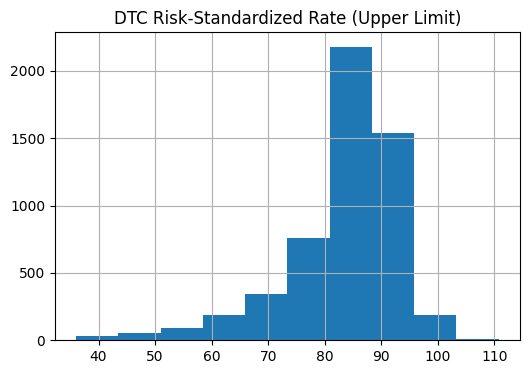

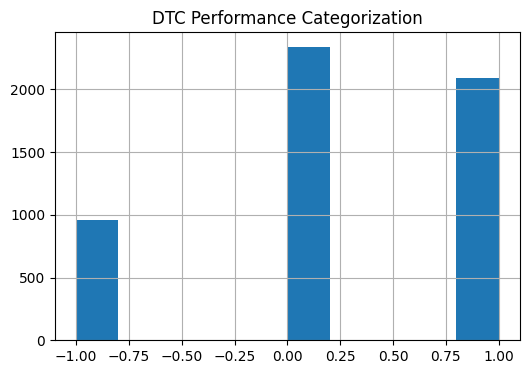

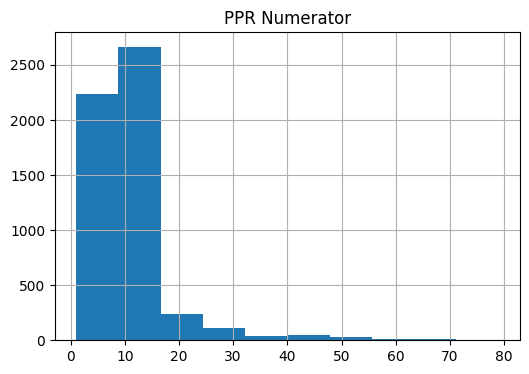

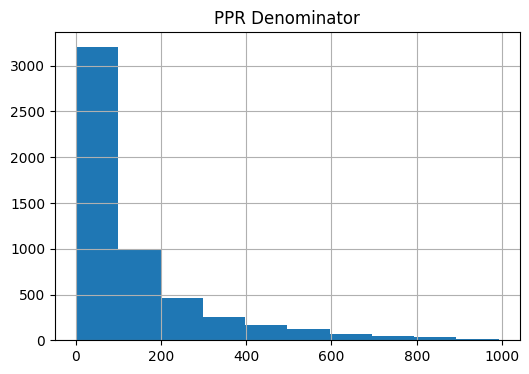

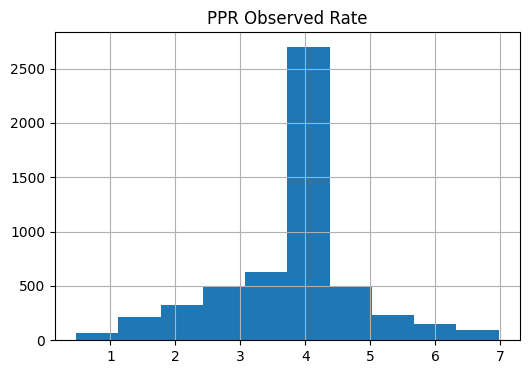

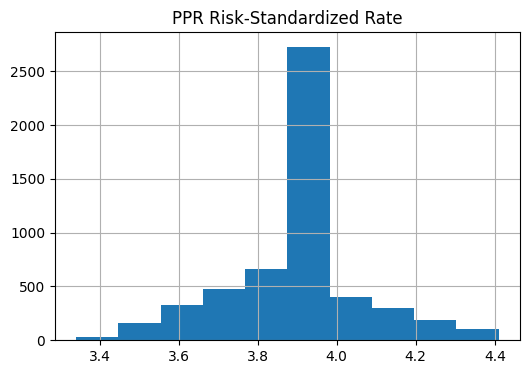

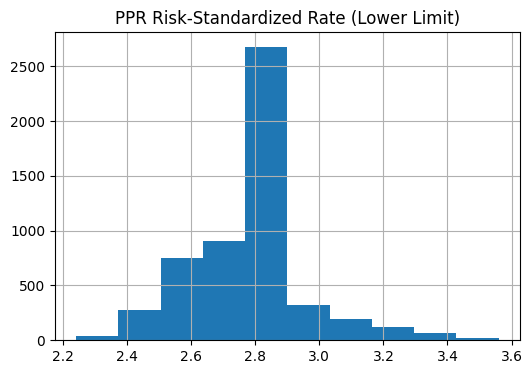

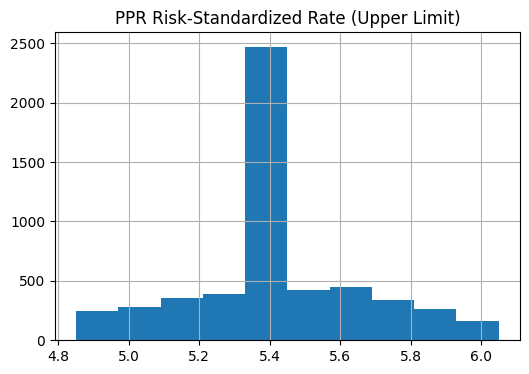

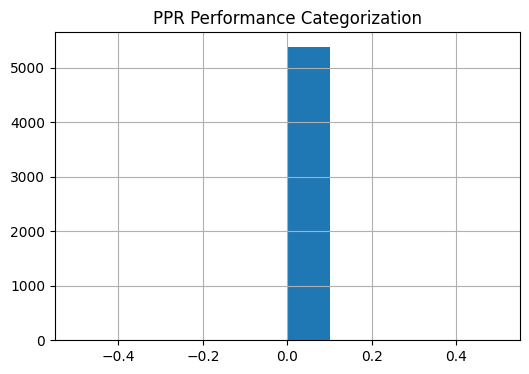

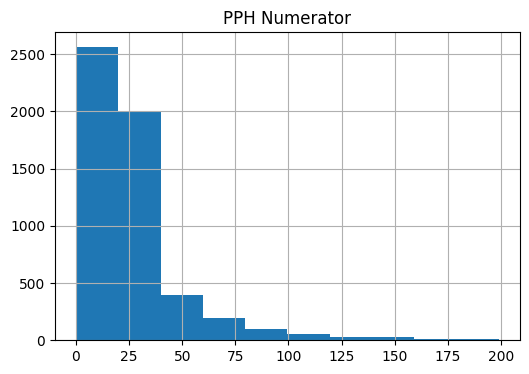

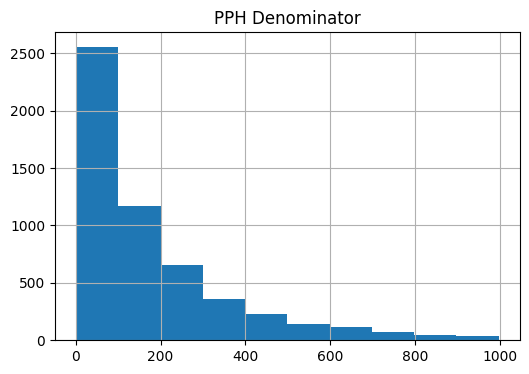

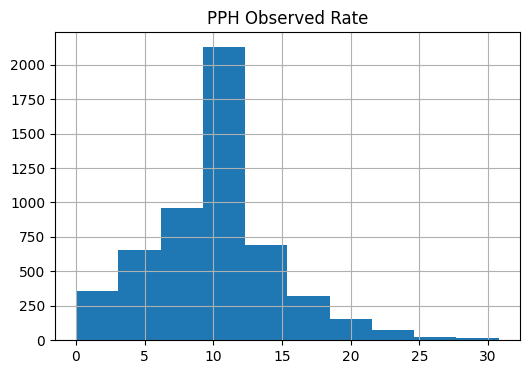

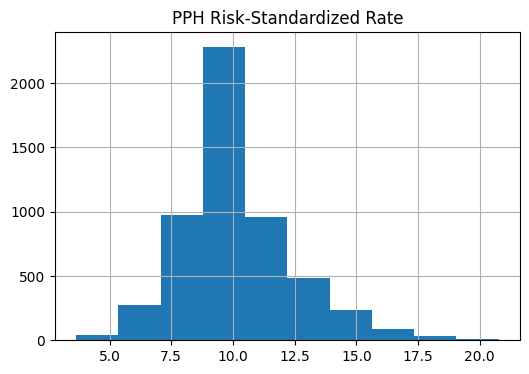

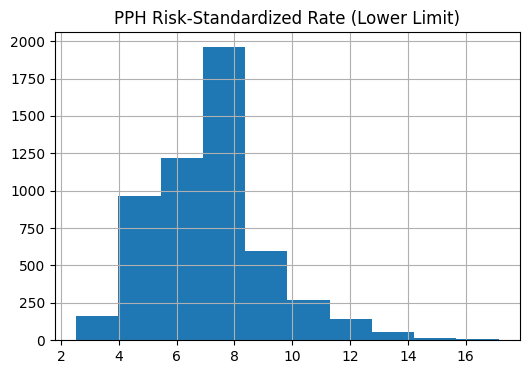

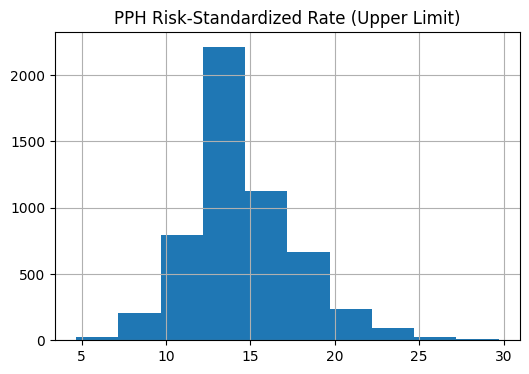

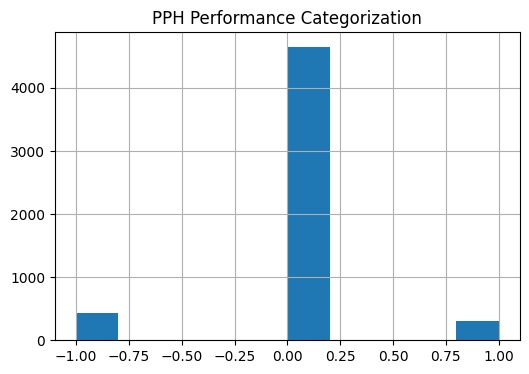

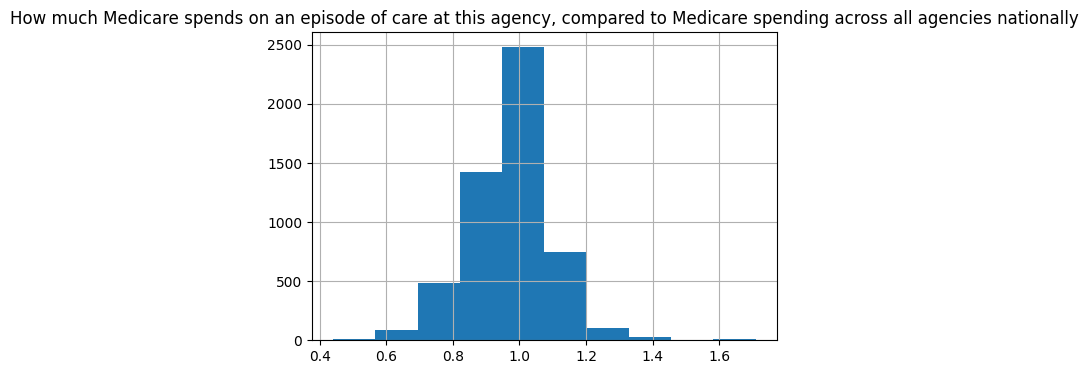

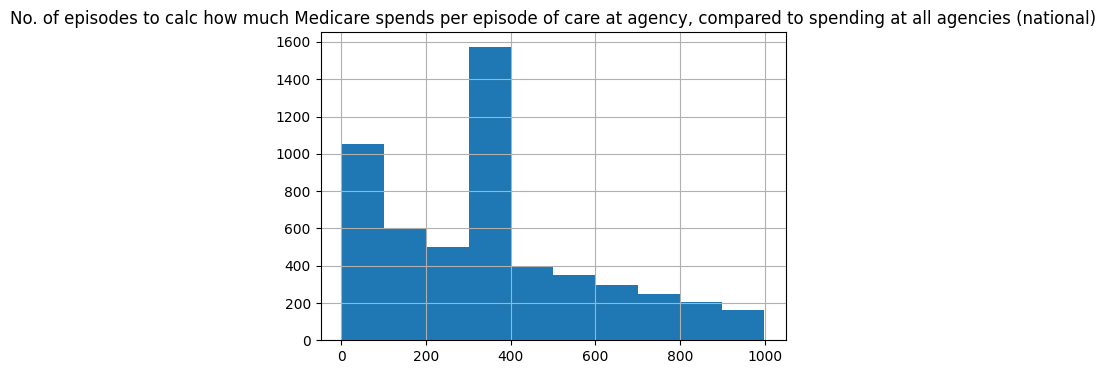

Atributele selectate sunt:
--------------------------------------------------------------------------------------------------------------------------------------------

Componenta principală 1:
DTC Denominator                                                                                                                                             5.469915e-01
DTC Numerator                                                                                                                                               4.605376e-01
No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             4.339308e-01
PPH Denominator                                                                                                                                             4.183971e-01
PPR Denominator                                                                                                                   

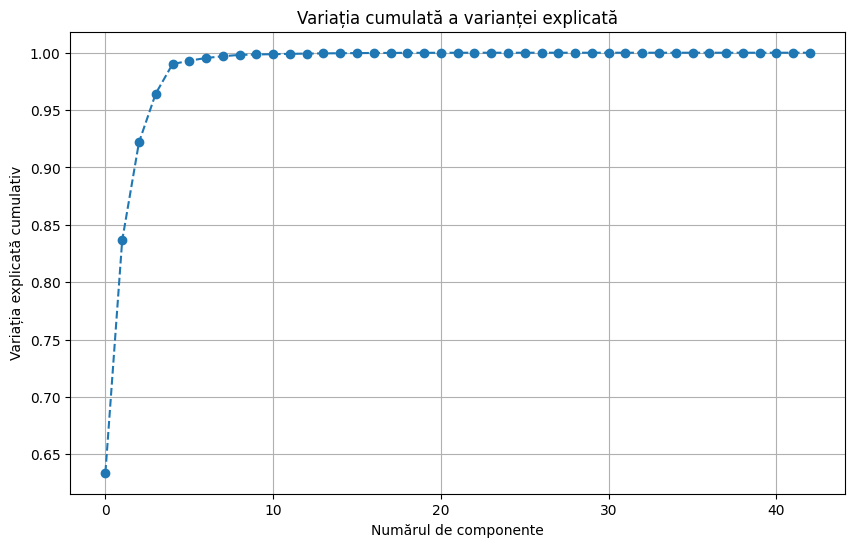

In [256]:
def main():
    data = FeedbackHHC(r'HH_Provider_Oct2023.csv')
    ok=0
    for col in data.data.columns:
        if data.type_number(col):
            ok+=1
    data.preprocessdata()
    data.data.to_csv('HH_Provider_Oct2023_preprocessed.csv')
    
    data.exploratory_analysis()
    data.select_attributes()


if __name__ == "__main__":
    main()